In [87]:
pip install tabulate

In [77]:
import pandas as pd 
import numpy as np 
from ast import literal_eval
from tabulate import tabulate
from prettytable import PrettyTable

In [3]:
movies = pd.read_parquet("tmbd_exports/tmbd_5000_api-call_merged.parquet")

In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'director'],
      dtype='object')

* STEP 1: TURN STRING COLUMNS INTO USEABLE OBJECTS

In [12]:
# List of columns that need fixing
columns_to_fix = ['cast', 'genres', 'director','keywords']

# Convert raw comma-separated text into properly formatted lists (Vectorized)
movies[columns_to_fix] = movies[columns_to_fix].apply(lambda col: 
    col.str.split(', ').apply(lambda x: str(x) if isinstance(x, list) else "[]")
)

# Apply literal_eval to convert them into actual lists
movies[columns_to_fix] = movies[columns_to_fix].applymap(literal_eval)

C:\Users\sara\AppData\Local\Temp\ipykernel_25620\3398161126.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  movies[columns_to_fix] = movies[columns_to_fix].applymap(literal_eval)


In [14]:
#check
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",[James Cameron],"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...",[Gore Verbinski],"[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",[Sam Mendes],"[spy, based on novel, secret agent, sequel, mi6]","[Action, Adventure, Crime]"


In [16]:
#return the list top 3 elements or entire list, whichever is more. This makes the handling
def get_list(x):
    if isinstance(x, list):
        # Check if the list contains dictionaries or just plain strings -> fixes potential TypeError:string indices must be integers, not 'str'
        if all(isinstance(i, dict) for i in x):  
            names = [i['name'] for i in x if 'name' in i]  # Extract 'name' if it's a dictionary
        else:
            names = x  # If it's a list of strings, use it directly
        
        # Return top 3 elements or the entire list
        return names[:3] if len(names) > 3 else names
    
    return []  # Return an empty list if data is missing/malformed

# Define the features to apply the function
features = ['cast', 'keywords', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [18]:
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron],"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes],"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [24]:
#convert all into lower case and strip spaces so that the vectorizer does not count the Johnny of Johnny Depp and Johnny Galecki as the same
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


#apply clean data function to features
features=['cast', 'keywords', 'director', 'genres']
for feature in features:
    movies[feature]=movies[feature].apply(clean_data)

* STEP 2: CREATE METADATASOUP = string that contains all the metadata we want to feed the vectorizer (actors, director, keywords)

In [29]:
def create_soup(x):
    # Ensure all columns are lists before joining
    keywords = ' '.join(x['keywords']) if isinstance(x['keywords'], list) else ''
    cast = ' '.join(x['cast']) if isinstance(x['cast'], list) else ''
    director = x['director'] if isinstance(x['director'], str) else ''
    genres = ' '.join(x['genres']) if isinstance(x['genres'], list) else ''
    
    return keywords + ' ' + cast + ' ' + director + ' ' + genres

movies['soup']=movies.apply(create_soup, axis=1)

In [31]:
movies.soup

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
1266       iangamazon edwinlagda edgartancangco  thriller
1267     edwardburns caitlinfitzgerald kerrybishé  com...
1268    loveatfirstsight date narration ericmabius kri...
1269     danielhenney elizacoupe billpaxton  romance c...
1270    obsession dreamgirl crush drewbarrymore brianh...
Name: soup, Length: 6068, dtype: object

* STEP 3: CREATE SIMILARITY MATRIX USING COUNT VECTORIZER

The matrix could be created using two different methods: TF-IDF and Count Vectorizer (see here for explanation of differences: https://github.com/UtkuEla/movie_picker/blob/sara_development/TF%20IDF%20vs%20Count%20Vectorizer.pdf )
In this case I will use the Count Vectorizer because the TF-IDF could downweight the presence of an actor/director if he has acted or directed more movies. This is because CountVectorizer treats all words equally based on their frequency in a document, while TF-IDF adjusts the importance of a word, making rare words in a document stand out more compared to frequent but less informative words.

In [39]:
#import countvectorizer and create a count matrix
from sklearn.feature_extraction.text import CountVectorizer
#define the CountVectorizer Object. Remove all words like the, a
count=CountVectorizer(stop_words='english')
#construct the matrix by building and fitting the data
count_matrix=count.fit_transform(movies['soup'])

Now that we have vectorized the text and created a count matrix, we can build the SIMILARITY SCORE between movies in our dataset. This can be done using an eucledian, Pearson or cosine similarity score. They are all viable options. We will be using the cosine similarity score:
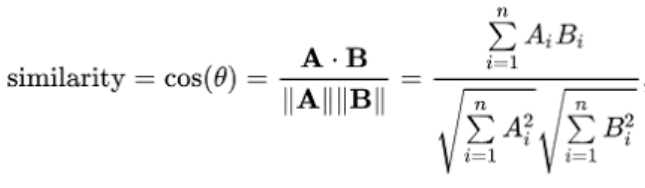

In [51]:
#compute the cosine similarity matrix based on count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim=cosine_similarity(count_matrix, count_matrix)

In [53]:
#resest index of main DF and construct reverse mapping, this allows to identify the index of a movie in our dataframe given its title
movies=movies.reset_index()
indices=pd.Series(movies.index, index=movies['title'])

* STEP 4: DEFINE RECOMMENDATION FUNCTION 

1. get the index of the movie given its title
2. get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second the similarity score
3. sort the tuples by similairty score (second element of the tuple)
4. get top 10 elements ignorign the first element since it refers to self
5. return the titles corresponding to the indices of the top elements

In [89]:
def get_recommendations(cosine_sim=cosine_sim):
    # Prompt the user to input a movie title
    user_input = input("Enter the name of the movie you want recommendations for: ").strip()

    # Check if the movie is in the dataset
    if user_input not in indices:
        print("Movie not found in the dataset. Please check the spelling and try again.")
        return pd.Series()  # Return an empty Series if the movie is not found

    # Get the index of the movie that matches the title
    idx = indices[user_input]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies.iloc[movie_indices]

# Call the function to get recommendations
recommended_movies = get_recommendations()

# Check if the recommended movies list is empty
if recommended_movies.empty:
    print("\nNo recommendations found for the selected movie.")
else:
    # Print the top 10 movies in a neat table format using tabulate
    print("\nTop 10 Recommended Movies:")
    print(tabulate(recommended_movies[['title', 'genres', 'overview', 'director','cast']], 
                   headers='keys', tablefmt='pretty', showindex=False))  # table format

Enter the name of the movie you want recommendations for:  The Dark Knight Rises



Top 10 Recommended Movies:
+--------------------------+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+------------------------------------------------------+
|          title           |            genres            |                                                                                                                                                 